In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# own utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.tram_data_helpers import *
from scipy.special import logit


Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "exp_6_2"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json


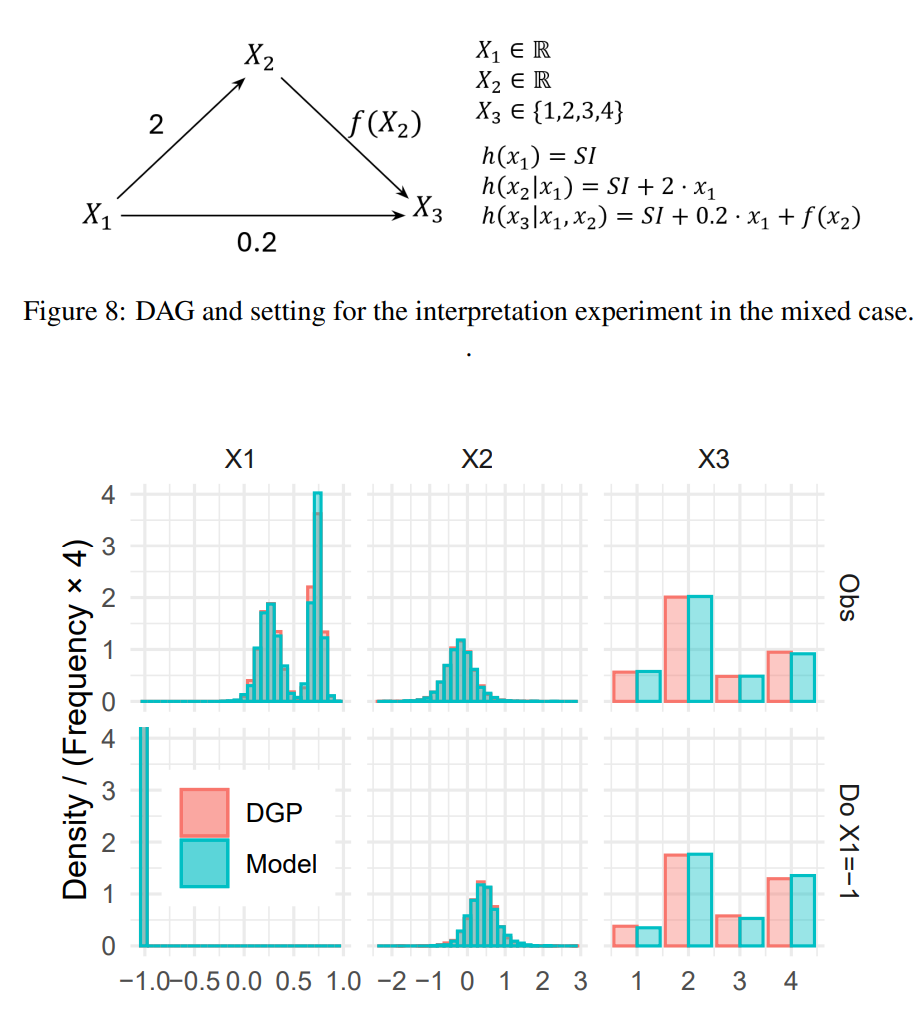

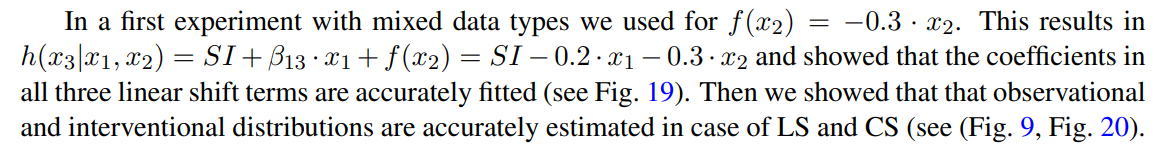

# 2.  Data

Loaded data from /home/bule/TramDag/dev_experiment_logs/exp_6_2/exp_6_2.csv
Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as an ordinal   variable. As PREDICTOR: OneHot and TARGET: OneHot.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB


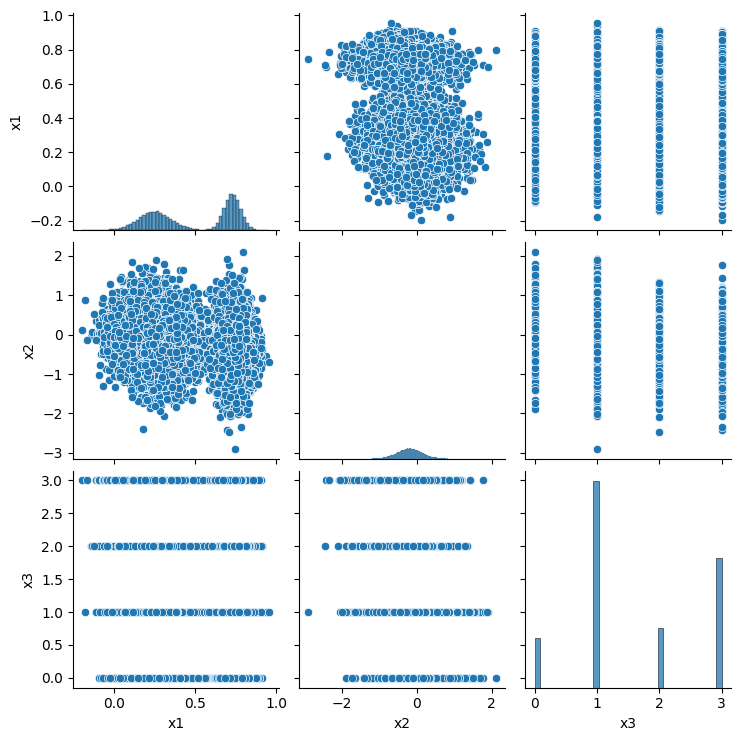

In [3]:
def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})



EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=100000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

train_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR, f"{experiment_name}_test.csv"), index=False)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 80000, Validation size: 10000, Test size: 10000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/configuration.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


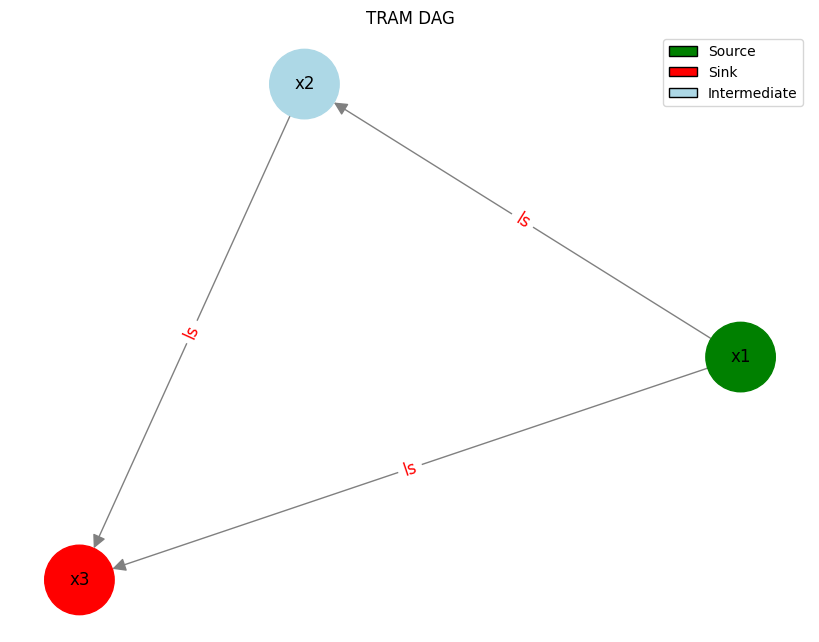

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

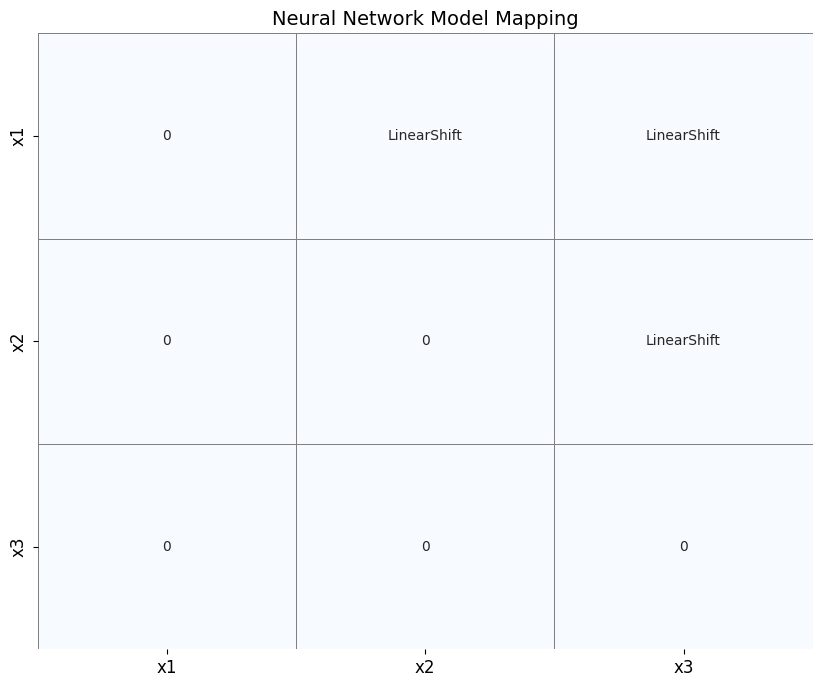

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12157964485414735, 'max': 0.794303998711493, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'internal', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.8069206639187695, 'max': 0.418925659248077, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}, 'x3': {'Modelnr': 2, 'data_type': 'ordinal_Xn_Yo', 'levels': 4, 'node_type': 'sink', 'parents': ['x1', 'x2'], 'parents_datatype': {'x1': 'continous', 'x2': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls'), 'x2': np.str_('ls')}, 'min': 0.0, 'max': 3.0, 'batch_size'

### --------------------- 

In [8]:
# hyperparams:
train_list=['x1','x2','x3']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)

# if you change the hyperparams -> write them to the config file!

In [9]:
# For each NODE 
node_list = configuration_dict['nodes'] 

for node in node_list:
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Get hyperparameters ###############################
    # batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 500
    learning_rate = 0.01
    use_scheduler = False
    ###########################################
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}\n")
    
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, configuration_dict, debug=False, set_initial_weights=True)
    
    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, debug=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=True,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols




----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Using hyperparameters: batch_size=512, epochs=500, learning_rate=0.01, use_scheduler=False

No existing model found. Starting fresh...


/home/bule/TramDag/utils/tram_model_helpers.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 1.6193  Val NLL: 1.1862  [Train: 2.61s  Val: 0.42s  Total: 3.03s]
Saved new best model.
Epoch 2/500  Train NLL: 0.9136  Val NLL: 0.6694  [Train: 2.38s  Val: 0.43s  Total: 2.81s]
Saved new best model.
Epoch 3/500  Train NLL: 0.5183  Val NLL: 0.3732  [Train: 2.39s  Val: 0.42s  Total: 2.81s]
Saved new best model.
Epoch 4/500  Train NLL: 0.2812  Val NLL: 0.1852  [Train: 2.03s  Val: 0.43s  Total: 2.46s]
Saved new best model.
Epoch 5/500  Train NLL: 0.1243  Val NLL: 0.0544  [Train: 2.29s  Val: 0.43s  Total: 2.72s]
Saved new best model.
Epoch 6/500  Train NLL: 0.0111  Val NLL: -0.0430  [Train: 2.16s  Val: 0.41s  Total: 2.57s]
Saved new best model.
Epoch 7/500  Train NLL: -0.0750  Val NLL: -0.1189  [Train: 2.02s  Val: 0.39s  Total: 2.42s]
Saved new best model.
Epoch 8/500  Train NLL: -0.1436  Val NLL: -0.1801  [Train: 2.28s  Val: 0.38s  Total: 2.66s]
Saved new best model.
Epoch 9/500  Train NLL: -0.1994  Val NLL: -0.2308  [Train: 2.35s  Val: 0.41s 

/home/bule/TramDag/utils/tram_model_helpers.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 2.6167  Val NLL: 2.2319  [Train: 2.56s  Val: 0.46s  Total: 3.02s]
Saved new best model.
Epoch 2/500  Train NLL: 1.9641  Val NLL: 1.7208  [Train: 2.47s  Val: 0.46s  Total: 2.93s]
Saved new best model.
Epoch 3/500  Train NLL: 1.4985  Val NLL: 1.2922  [Train: 2.33s  Val: 0.43s  Total: 2.77s]
Saved new best model.
Epoch 4/500  Train NLL: 1.1585  Val NLL: 1.0429  [Train: 2.51s  Val: 0.47s  Total: 2.98s]
Saved new best model.
Epoch 5/500  Train NLL: 0.9105  Val NLL: 0.7973  [Train: 2.54s  Val: 0.50s  Total: 3.05s]
Saved new best model.
Epoch 6/500  Train NLL: 0.7419  Val NLL: 0.6943  [Train: 2.57s  Val: 0.44s  Total: 3.01s]
Saved new best model.
Epoch 7/500  Train NLL: 0.6670  Val NLL: 0.6383  [Train: 2.58s  Val: 0.44s  Total: 3.03s]
Saved new best model.
Epoch 8/500  Train NLL: 0.6221  Val NLL: 0.6012  [Train: 2.61s  Val: 0.47s  Total: 3.08s]
Saved new best model.
Epoch 9/500  Train NLL: 0.5910  Val NLL: 0.5744  [Train: 2.44s  Val: 0.45s  Total:

/home/bule/TramDag/utils/tram_model_helpers.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tilde = torch.tensor(theta_tilde, dtype=last_linear.weight.dtype, device=last_linear.weight.device)


Saved new best model.
Epoch 1/500  Train NLL: 1.2185  Val NLL: 1.2076  [Train: 3.43s  Val: 0.59s  Total: 4.03s]
Epoch 2/500  Train NLL: 1.2131  Val NLL: 1.2078  [Train: 3.21s  Val: 0.59s  Total: 3.80s]
Epoch 3/500  Train NLL: 1.2128  Val NLL: 1.2079  [Train: 3.40s  Val: 0.59s  Total: 3.99s]
Saved new best model.
Epoch 4/500  Train NLL: 1.2129  Val NLL: 1.2074  [Train: 3.52s  Val: 0.58s  Total: 4.10s]
Saved new best model.
Epoch 5/500  Train NLL: 1.2128  Val NLL: 1.2073  [Train: 3.14s  Val: 0.60s  Total: 3.74s]
Epoch 6/500  Train NLL: 1.2131  Val NLL: 1.2075  [Train: 3.28s  Val: 0.62s  Total: 3.91s]
Saved new best model.
Epoch 7/500  Train NLL: 1.2131  Val NLL: 1.2073  [Train: 3.29s  Val: 0.59s  Total: 3.89s]
Epoch 8/500  Train NLL: 1.2131  Val NLL: 1.2073  [Train: 3.25s  Val: 0.58s  Total: 3.84s]
Epoch 9/500  Train NLL: 1.2131  Val NLL: 1.2073  [Train: 3.40s  Val: 0.55s  Total: 3.95s]
Epoch 10/500  Train NLL: 1.2127  Val NLL: 1.2080  [Train: 3.26s  Val: 0.58s  Total: 3.85s]
Epoch 11/50

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 75220 to 15795
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      80000 non-null  float64
 1   x2      80000 non-null  float64
 2   x3      80000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 MB


# 6 Inspect Training

## 6.1 Loss vs epochs

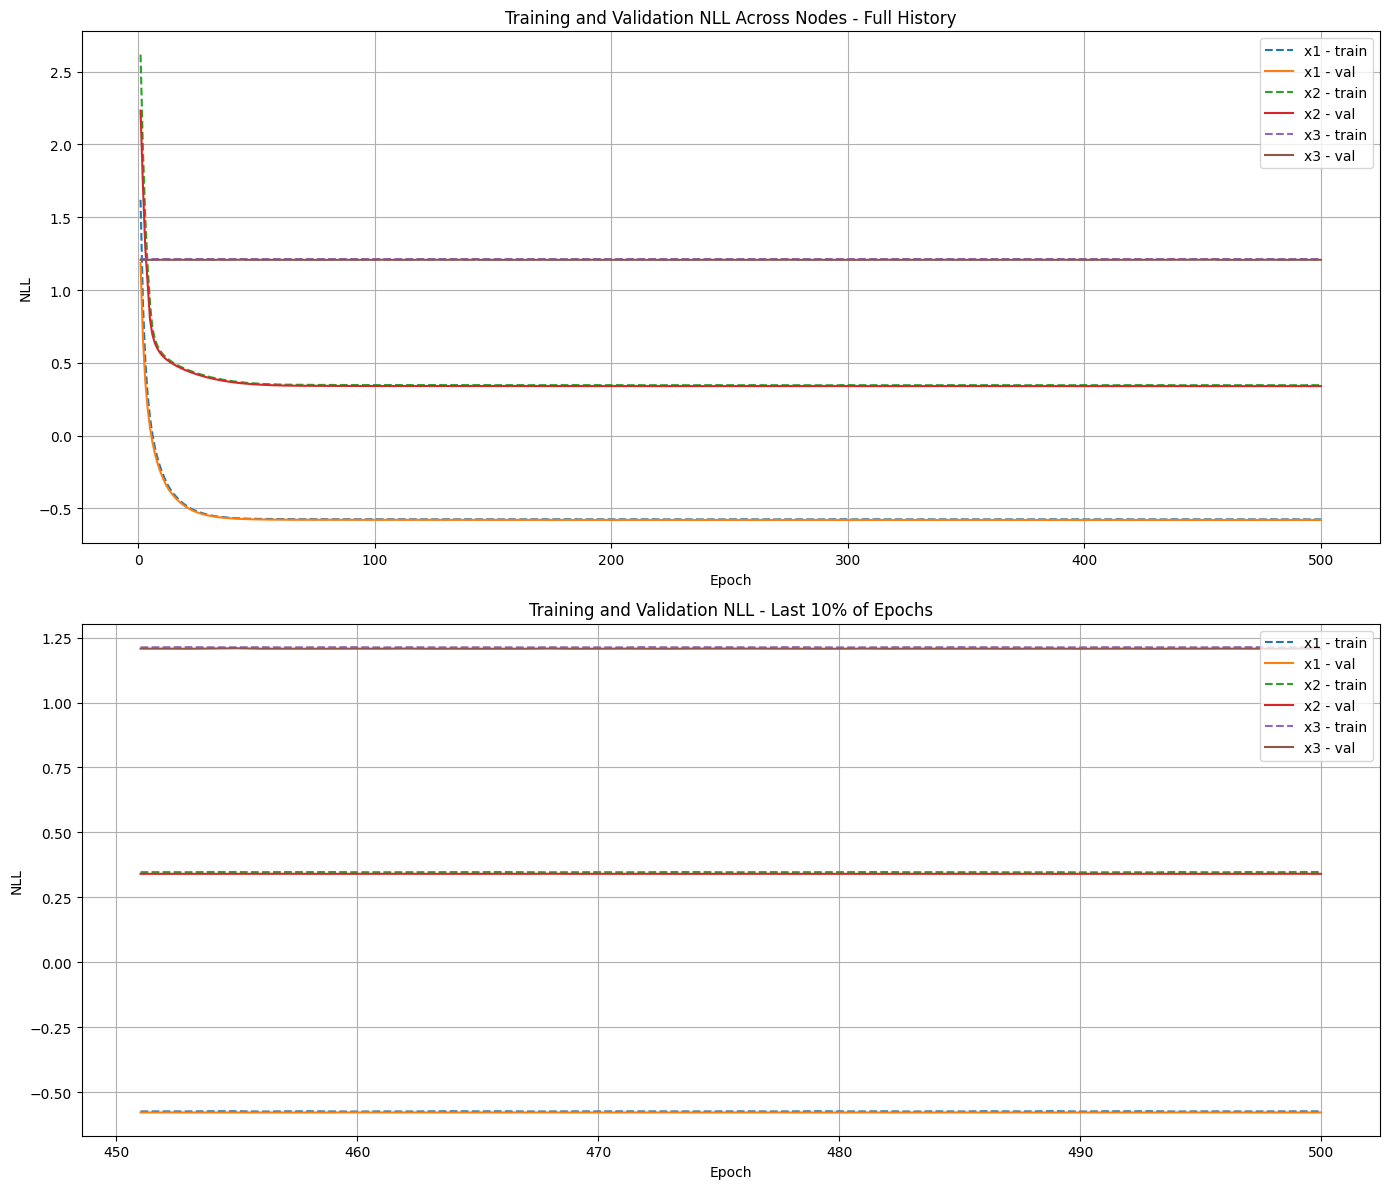

In [19]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


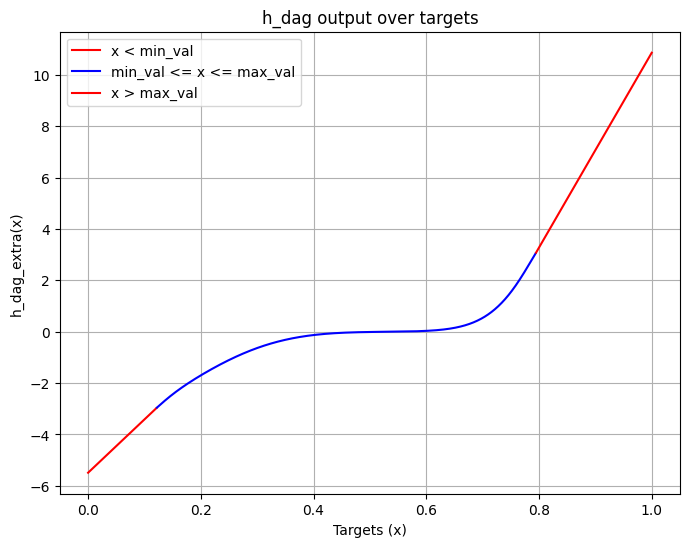

In [20]:
show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


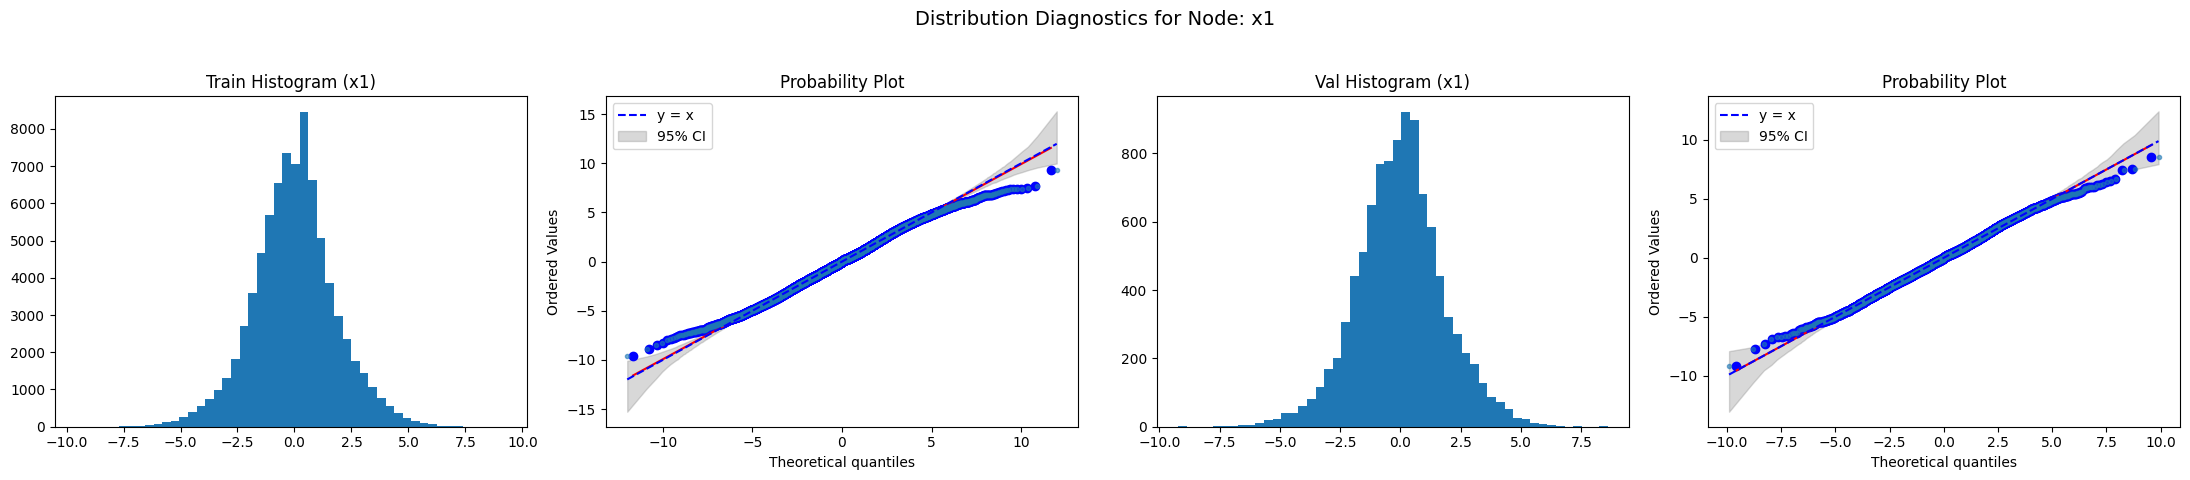

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


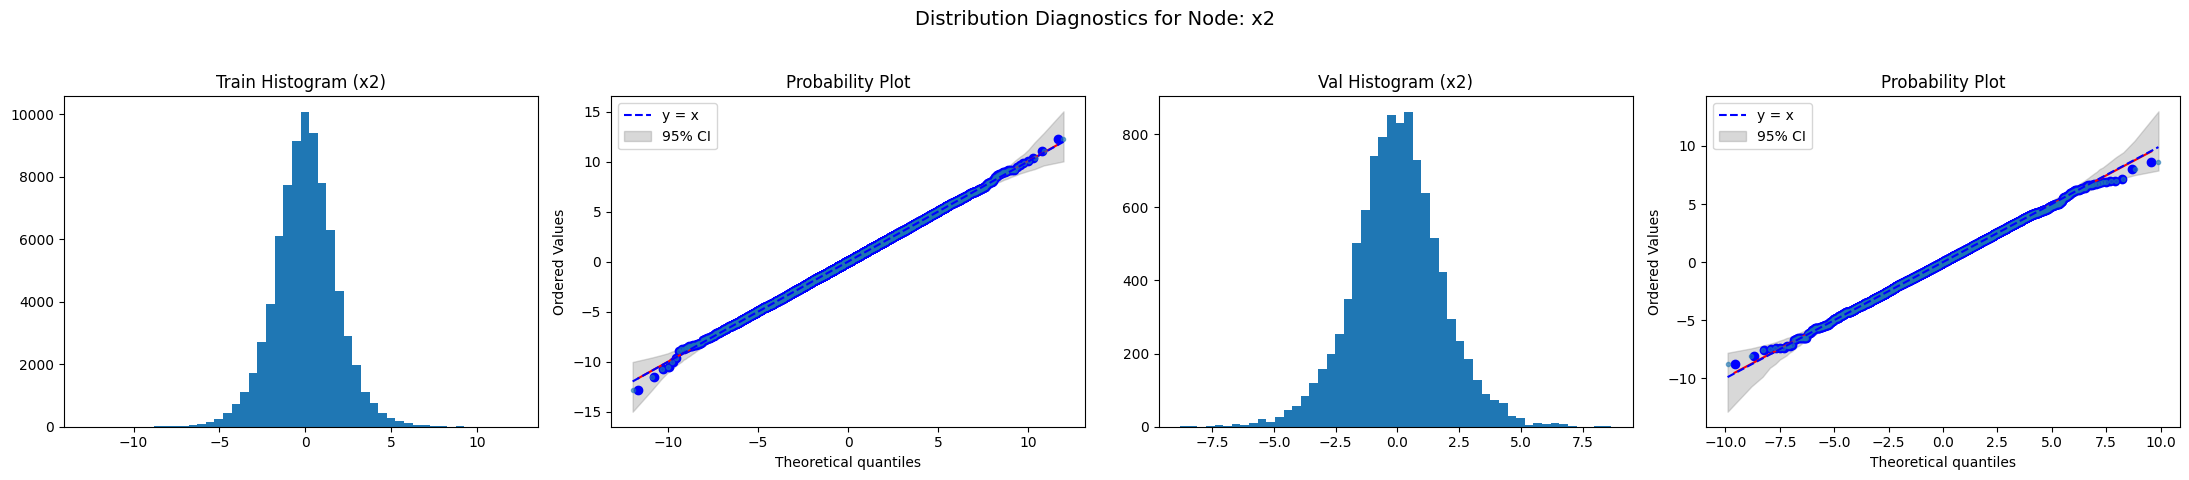

----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--
not defined for ordinal target variables


(array([[-1.7665497 , -0.4875462 ],
        [-2.98898   , -0.92713195],
        [ 1.9787626 ,  0.56008756],
        ...,
        [-0.32109353,  1.8630074 ],
        [ 0.6913687 , -2.688106  ],
        [-3.4262338 ,  1.2541257 ]], dtype=float32),
 array([[ 3.6667275 , -3.3345766 ],
        [-1.2184951 ,  2.0207794 ],
        [ 1.4118854 ,  0.0361743 ],
        ...,
        [-1.163412  ,  1.3619976 ],
        [ 0.2985344 ,  1.5711232 ],
        [ 0.00410608,  1.1975405 ]], dtype=float32))

In [21]:

inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

# 7. Sample from Graph

In [22]:

all_latents_df = create_latent_df_for_full_dag(configuration_dict, EXPERIMENT_DIR, train_df, verbose=True)
all_latents_df.head()

[INFO] Processing node 'x1'
[INFO] Processing node 'x2'
[INFO] Skipping node 'x3' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (80000, 4)


,x1,x1_U,x2,x2_U
75220,0.729475,1.028141,-0.573516,-1.401068
48955,0.212327,-1.543021,-0.198221,-0.551004
44966,0.219109,-1.459152,0.129154,1.114308
13568,0.777640,2.447093,0.816980,5.692506
92727,0.357308,-0.281634,-0.411472,-1.324233


In [23]:
sampled_by_node, latents_by_node=sample_full_dag(configuration_dict,
                EXPERIMENT_DIR,
                device,
                do_interventions={},
                predefined_latent_samples_df=None,#all_latents_df,
                number_of_samples= 10_000,
                batch_size = 32,
                delete_all_previously_sampled=True,
                verbose=True,
                debug=False)

[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 329.87it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 330.97it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


## 7.3 Inspect Sampling

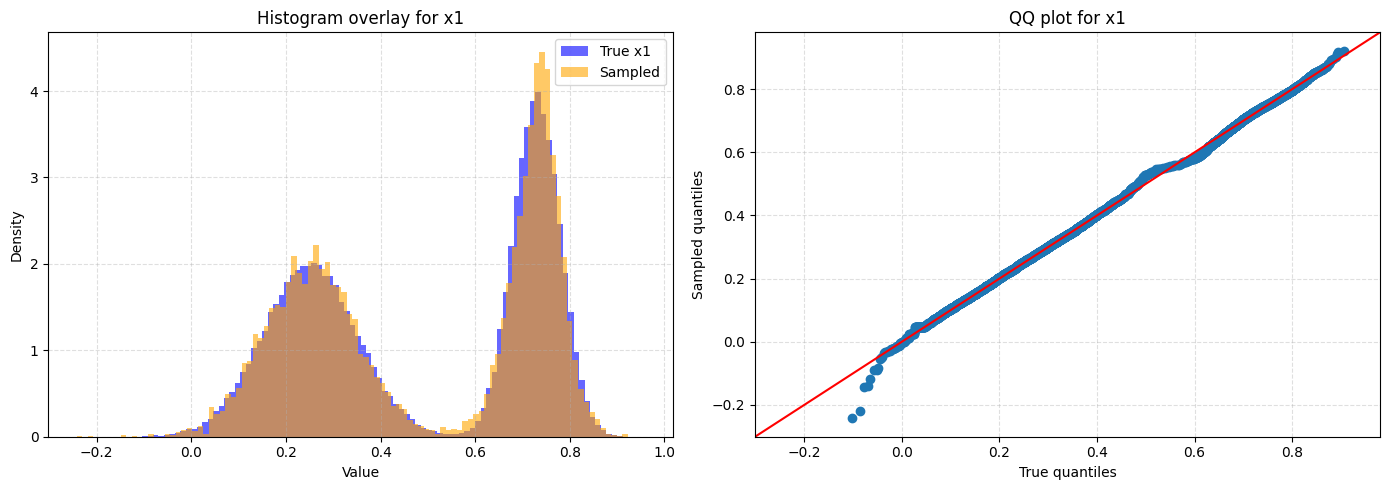

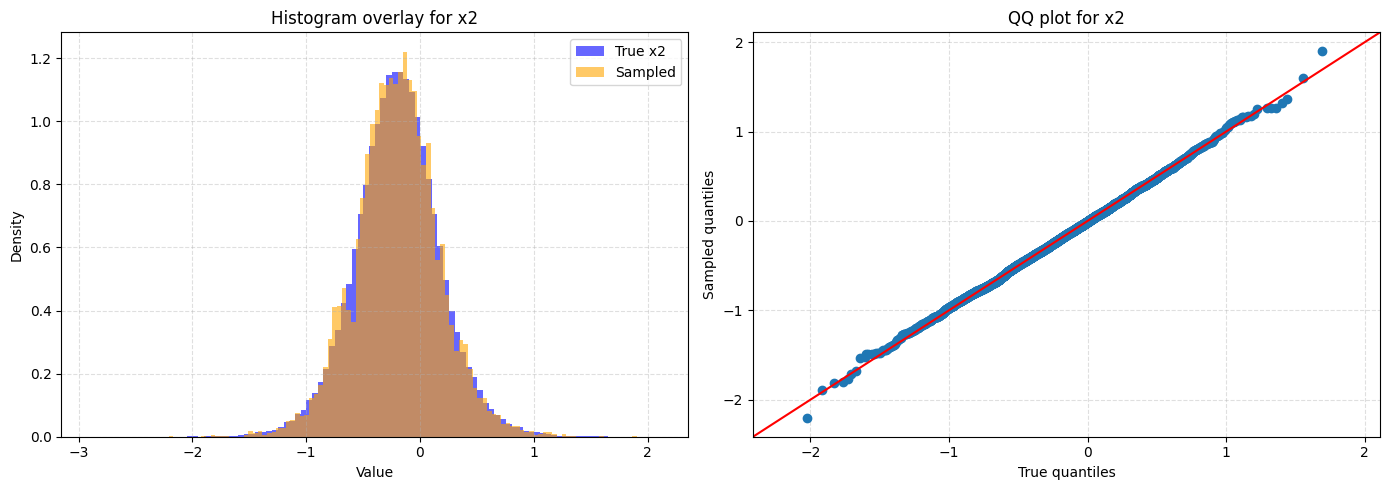

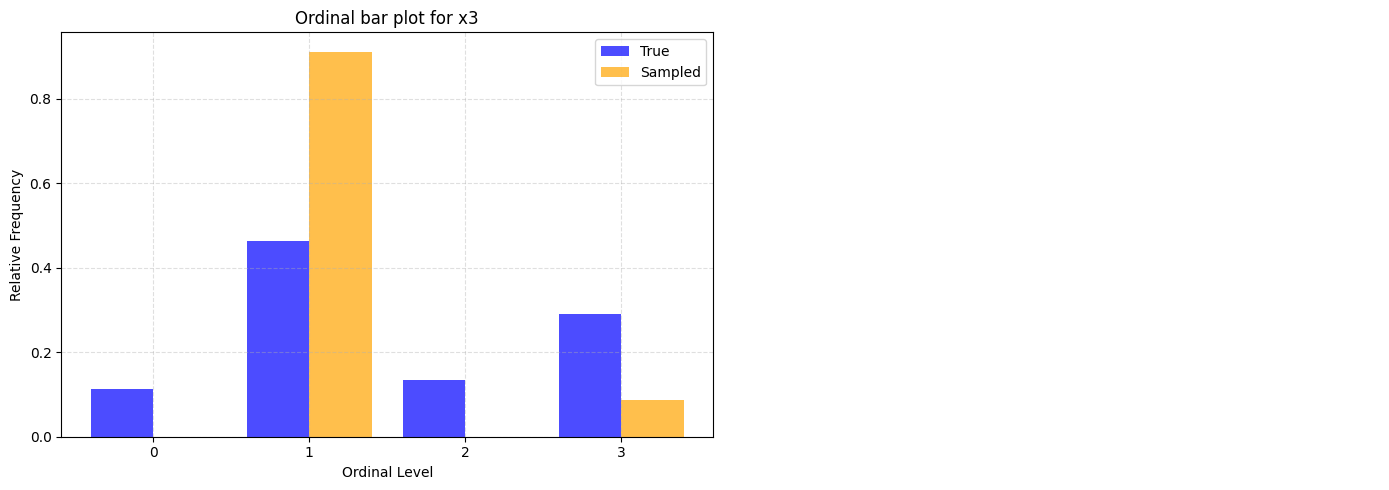

In [24]:
show_samples_vs_true(train_df,node_list,EXPERIMENT_DIR)

## 7.4 Intervention

In [17]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

ValueError: Seed must be between 0 and 2**32 - 1

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')